#  Summary of what this capstone will, and may accomplish

* Scrape data from indeed, and return job postings
* properly format location, title, requirements (location done, 
* analyze what words and requirements occur the most
* Determine the quality of each job posting (how generic does it sound, and how common are the phrases that they are using) - this is important, but needs a bit of refinement
* Compare correlation between words used and position

Not required, but would be nice to implement
* add a map to visualize how many postings there are in each city 

Associated web scraper script can be found at 
https://github.com/mhuh22/Thinkful/blob/master/Bootcamp/Unit%207/Indeed%20Job%20Scraper.ipynb

# Packages

In [1]:
# Basic imports
import os
import time
import timeit
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning packages
from sklearn import ensemble
from sklearn.feature_selection import chi2, f_classif, SelectKBest 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import normalize

# Natural Language processing
import nltk
import re
import spacy
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_rcv1
from sklearn.feature_extraction.text import TfidfVectorizer

# Clustering packages
import sklearn.cluster as cluster
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
from scipy.spatial.distance import cdist

# Plotly packages
import plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly import tools
import cufflinks as cf
import ipywidgets as widgets
from scipy import special
py.offline.init_notebook_mode(connected=True)

In [2]:
# Import the dataframe
job_data = pd.read_csv('data/job_board.csv', index_col=False)
job_data.drop(['Unnamed: 0'], 1, inplace=True)

In [3]:
# Let's check up on the size of our dataframe
job_data.shape

(671, 7)

In [4]:
# Preview the data
job_data

,Title,Location,Company,Salary,Synopsis,Query,Metro
0,Data Analyst,"Duluth, MN",Members Cooperative Credit Union,None,The Data Analyst i...,data+analyst,united states
1,Data Analyst,"Elgin, IL",voestalpine High Performance Metals Co...,None,Proven work experi...,data+analyst,united states
2,Data Analyst,"Jersey City, NJ 07311 (Downtown area)",Tradeweb Markets LLC,None,Tradeweb has an op...,data+analyst,united states
3,Web Data Analyst,"Pleasant Prairie, WI 53158",Uline,None,Web Data Analyst. ...,data+analyst,united states
4,SAS Programmer (Data Analyst),"Washington, DC","Oasis Systems, Inc.",None,Perform data proce...,data+analyst,united states
5,CLINICAL SYSTEM DATA ANALYST (STATISTICAL PROG...,"Philadelphia, PA 19102 (City Center West area)",Temple Health,None,Provides clinical ...,data+analyst,united states
6,Junior Data Analyst,"Valhalla, NY",Rectangle Health,None,Data visualization skills (ex. As the Junior D...,data+analyst,united states
7,Business / Data Analyst,"New York, NY 10038 (Financial District area)",Bank of America,None,"Proficient with Data modeling, SQL...",data+analyst,united states
8,Data Analyst,"New York, NY 10005 (Financial District area)",Murmuration,None,The Data Analyst will:. The Data A...,data+analyst,united states
9,Jr. Data Analyst (Data Assurance) ~ Entry Level,"Jersey City, NJ",Genuent,\r\n $20 - $25 an hour,"Data Analyst (Data Assurance) ~ Jersey City, N...",data+analyst,united states


In [5]:
# Doing some data cleaning
for i, row in job_data.iterrows():
    
    # Clean up location column to format 'city, state'
    (job_data['Location'][i]) = ' '.join((job_data['Location'][i]).split(' ', 2)[:2]) 
    
    # Clean up summary column (Better, but doesn't completely remove all whitespace)
    (job_data['Synopsis'][i]) = (job_data['Synopsis'][i]).strip()

In [6]:
# Print number of unique categories for all non-numerical columns
job_data.select_dtypes(include=['object']).nunique()

Title       189
Location    155
Company     338
Salary       76
Synopsis    635
Query         3
Metro         1
dtype: int64

In [7]:
# # View all job titles (Not that useful since there are a LOT)
# plt.rcParams['figure.figsize'] = [20,5]
# plt.xticks(rotation=70)
# plt.title('Title Frequency')

# sns.barplot(job_data['Title'].unique(), job_data['Title'].value_counts(), data=job_data)

# Data Visualization

In [8]:
# Print out unique job titles and frequencies
job_data['Title'].value_counts()

Data Scientist                                                     119
Data Analyst                                                       104
Data Engineer                                                       75
Junior Data Scientist                                               13
Big Data Engineer                                                    7
Junior Data Analyst                                                  7
Data Analyst Intern                                                  5
Product Data Analyst                                                 5
Data Entry Analyst                                                   5
Entry Level Business Analyst                                         5
Data Analyst (Entry Level)                                           5
Junior Data Engineer                                                 4
Data Scientist / Predictive Modeler                                  4
Associate Data Scientist                                             4
DATA S

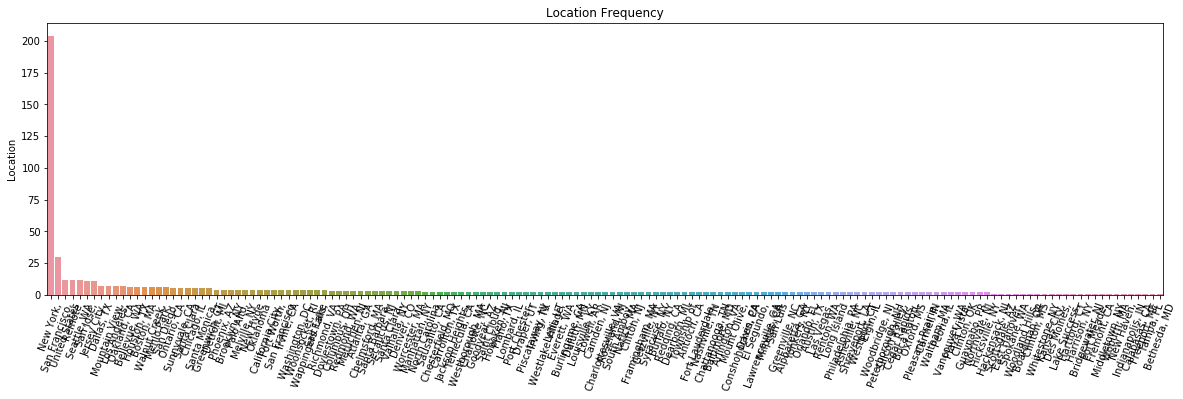

In [9]:
# Plot occurences of each location
# (Not used for anything yet, idk if I'll keep it)
plt.rcParams['figure.figsize'] = [20,5]
plt.xticks(rotation=70)
plt.title('Location Frequency')
x = job_data['Location'].value_counts().index.tolist()
y = job_data['Location'].value_counts()

sns.barplot(x, y, data=job_data)

In [10]:
# Create series with location count
# (Not used for anything yet, idk if I'll keep it)
location_data = job_data['Location'].value_counts()
location_data

New York,           204
San Francisco,       30
United States        12
Remote               12
Seattle, WA          12
San Jose,            11
Jersey City,         11
Dallas, TX            7
Mountain View,        7
Los Angeles,          7
Oakland, CA           7
Bellevue, WA          6
Houston, TX           6
Boston, MA            6
Walnut Creek,         6
Menlo Park,           6
San Diego,            6
Ontario, CA           5
Sunnyvale, CA         5
Santa Clara           5
Chicago, IL           5
Santa Monica,         5
Greenwich, CT         5
Detroit, MI           4
Phoenix, AZ           4
Brooklyn, NY          4
Palo Alto,            4
Melville, NY          4
New Hyde              4
Oklahoma              4
                   ... 
Vancouver, WA         2
Playa Vista,          2
Clinton, OK           2
Guaynabo, PR          2
Northvale, NJ         2
Hicksville, NY        2
Hackensack, NJ        1
Scottsdale, AZ        1
East Hanover,         1
Spokane, WA           1
Woodland Hills, 

In [11]:
# # Cleans up salary data
# # (Not sure if I care about salary, but it's here if I need it and it's interesting)

# # Create salary dataframe for postings with salary information
# salary_data = job_data.replace(to_replace='None', value=np.nan).dropna()

# # Cleaning up salary data
# salary_data = salary_data[(~salary_data.Salary.str.contains('an hour')) & (~salary_data.Salary.str.contains('a month'))
#                    & (~salary_data.Salary.str.contains('a week')) & (~salary_data.Salary.str.contains('a day'))]
# salary_data.Salary = salary_data.Salary.str.replace('a year', '').str.replace(',', '').str.replace('$', '')

# # Update salary values
# new_salaries = []
# for i in salary_data.Salary:
#     a = i.split('-')
#     if len(a) == 2:
#         new_salaries.append(np.mean([float(b) for b in a]))
#     else:
#         new_salaries.append(float(a[0]))        
# salary_data.Salary = new_salaries

# # Creates boxplots of the occupations
# data_analyst = go.Box(
#     y=salary_data['Salary'].loc[salary_data['Query']=='data+analyst']
# )
# data_scientist = go.Box(
#     y=salary_data['Salary'].loc[salary_data['Query']=='data+scientist']
# )
# data_engineer = go.Box(
#     y=salary_data['Salary'].loc[salary_data['Query']=='data+engineer']
# )
# layout = go.Layout(
#     title = 'Salary Comparison by Query'
# )
# data = [data_analyst,data_scientist,data_engineer]
        
# fig = go.Figure(data=data,layout=layout)
# py.offline.iplot(fig)

<div class="alert alert-block alert-warning">
1. Each salary was computed by converting non-annual salary rates to annual, and taking the average of all ranges. The actual minimum and maximum values are most likely lower and higher respectively.

2. Very few employers (<20%) on Indeed include the salary in the listing (meaning that the numbers shown above are likely higher than the actual numbers.
</div>

# Text Cleaning

In [12]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [13]:
# Remove annoying punctuation from the articles
pd.options.display.max_colwidth = 200
job_data['Synopsis'] = job_data.Synopsis.map(lambda x: text_cleaner(str(x)))
job_data['Synopsis'].head()

0         The Data Analyst is responsible for the collection, analysis and reporting of client/customer data using complex analysis of datasets in areas of research,...
1                                               Proven work experience (preferably 2-3 years) as a data analyst or business data analyst. Job Posting – Data Analyst....
2            Tradeweb has an opening for a Data Analyst within their Market Data group. Candidates should have strong technical skills related to data analysis, data...
3      Web Data Analyst. Uline seeks a Web Data Analyst at its Corporate Headquarters in Pleasant Prairie, WI. Analyze data and provide weekly and monthly reports to...
4    Perform data processing to manipulate the data to prepare for reporting including linking the data to other data sources, formatting the data, supplementing the...
Name: Synopsis, dtype: object

# Natural Language Processing

In [14]:
lemmatizer = WordNetLemmatizer()

# Reduce all text to their lemmas
for summary in job_data['Synopsis']:
    summary = lemmatizer.lemmatize(summary)

In [15]:
# Predict job title using text data
X = job_data['Synopsis']
y = job_data['Query']

# Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Tf-idf vectorizer

In [16]:
# Parameters for TF-idf vectorizer
vectorizer = TfidfVectorizer(max_df=0.5,
                             min_df=5, 
                             max_features=150, 
                             stop_words='english', 
                             lowercase=True, 
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True
                            )

#Applying the vectorizer
X_tfidf=vectorizer.fit_transform(X)
print("Number of features: %d" % X_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=42)

#Removes all zeros from the matrix
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()

#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# Normalize the dataset    
X_norm = normalize(X_train_tfidf)

# Convert from tf-idf matrix to dataframe
X_normal  = pd.DataFrame(data=X_norm.toarray())

Number of features: 150


### Spacy

In [17]:
# Parameters for TF-idf vectorizer
vectorizer = TfidfVectorizer(max_df=0.5,
                             min_df=5, 
                             max_features=150, 
                             stop_words='english', 
                             lowercase=True, 
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True
                            )

#Applying the vectorizer
X_tfidf=vectorizer.fit_transform(X)
print("Number of features: %d" % X_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=42)

#Removes all zeros from the matrix
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()

#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# Normalize the dataset    
X_norm = normalize(X_train_tfidf)

# Convert from tf-idf matrix to dataframe
X_normal  = pd.DataFrame(data=X_norm.toarray())

Number of features: 150


In [18]:
# Instantiating spaCy
nlp = spacy.load('en')
X_train_words = []

for row in X_train:
    # Processing each row for tokens
    row_doc = nlp(row)
    # Calculating length of each sentence
    sent_len = len(row_doc) 
    # Initializing counts of different parts of speech
    advs = 0
    verb = 0
    noun = 0
    adj = 0
    for token in row_doc:
        # Identifying each part of speech and adding to counts
        if token.pos_ == 'ADV':
            advs +=1
        elif token.pos_ == 'VERB':
            verb +=1
        elif token.pos_ == 'NOUN':
            noun +=1
        elif token.pos_ == 'ADJ':
            adj +=1
    # Creating a list of all features for each sentence
    X_train_words.append([row_doc, advs, verb, noun, adj, sent_len])

# Create dataframe with count of adverbs, verbs, nouns, and adjectives
X_count = pd.DataFrame(data=X_train_words, columns=['BOW', 'ADV', 'VERB', 'NOUN', 'ADJ', 'sent_length'])

# Change token count to token percentage
for column in X_count.columns[1:5]:
    X_count[column] = X_count[column] / X_count['sent_length']

# Normalize X_count
X_counter = normalize(X_count.drop('BOW',axis=1))
X_counter  = pd.DataFrame(data=X_counter)

In [19]:
# Combine tf-idf matrix and phrase count matrix
features = pd.concat([X_counter,X_normal], ignore_index=False, axis=1)
features.head()

,0,1,2,3,4,0,1,2,3,4,...,140,141,142,143,144,145,146,147,148,149
0,0.0,0.004444,0.006666,0.003333,0.999962,0.000000,0.0,0.0,0.000000,0.264864,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.000000,0.016459,0.002743,0.999861,0.000000,0.0,0.0,0.244969,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.005208,0.015623,0.006943,0.999840,0.000000,0.0,0.0,0.246113,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.236465,0.0,0.0
3,0.0,0.012395,0.010329,0.002066,0.999868,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.019994,0.012496,0.004999,0.999710,0.495445,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [20]:
# Calulate predicted values
kmeans = KMeans(n_clusters=job_data['Query'].nunique(), init='k-means++', random_state=42, n_init=20)
y_pred1 = kmeans.fit_predict(features)

pd.crosstab(y_train, y_pred1)

col_0,0,1,2
Query,,,
data+analyst,83,1,84
data+engineer,13,2,137
data+scientist,18,45,120


In [21]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y_train, y_pred1)))
print('Silhouette Score: {:0.7}'.format(silhouette_score(features, y_pred1, sample_size=60000, metric='euclidean')))

Adjusted Rand Score: 0.0839366
Silhouette Score: 0.02108852


In [22]:
X_train_cluster = pd.DataFrame(features)
X_train_cluster['kmeans'] = y_pred1

### Tf-idf Matrix

In [23]:
# Creating tf-idf matrix
vectorizer = TfidfVectorizer(stop_words='english')
synopsis_tfidf = vectorizer.fit_transform(job_data['Synopsis'])

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=job_data['Query'].nunique()

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 50

In [24]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Parameters for LSA
svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Time and run LSA model
start_time = timeit.default_timer()
synopsis_lsa = lsa.fit_transform(synopsis_tfidf)
elapsed_lsa = timeit.default_timer() - start_time

# Extract most common words for LSA
components_lsa = word_topic(synopsis_tfidf, synopsis_lsa, terms)
topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                

In [25]:
from sklearn.decomposition import NMF

# Parameters for NNMF
nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )

# Time and run NNMF model
start_time = timeit.default_timer()
synopsis_nmf = nmf.fit_transform(synopsis_tfidf)
elapsed_nnmf = timeit.default_timer() - start_time

# Extract most common words for NNMF
components_nmf = word_topic(synopsis_tfidf, synopsis_nmf, terms)
topwords['NNMF']=top_words(components_nmf, n_top_words)

In [26]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
                LSA              NNMF
0        data 63.24         data 6.32
0     analyst 15.84      analyst 1.81
0        team 13.08      engineer 1.7
0    business 12.83   experience 1.52
0    engineer 12.48     analysis 1.15
0    analysis 12.45  responsible 1.09
0  experience 12.22      sources 0.91
0        work 11.55      looking 0.83
0   analytics 11.22        years 0.82
0   scientist 10.07         team 0.78
0  responsible 8.95          new 0.78
0      looking 7.85    scientist 0.78
0           new 7.6     business 0.73
0      science 7.48   management 0.71
0        using 7.32    warehouse 0.71
0         sets 7.12          sets 0.7
0       support 7.0         work 0.69
0    management 6.9      support 0.67
0      insights 6.7         using 0.6
0      sources 6.64          big 0.55
0      product 6.63       design 0.55
0       working 6.5    reporting 0.52
0     learning 6.42  development 0.52
0        tools 6.41          join 0.5
0     engineers 6.4       seeking 0.5
0  

In [27]:
topwords['LSA'].str.split(' ', 0).str[0]

0              data
0           analyst
0              team
0          business
0          engineer
0          analysis
0        experience
0              work
0         analytics
0         scientist
0       responsible
0           looking
0               new
0           science
0             using
0              sets
0           support
0        management
0          insights
0           sources
0           product
0           working
0          learning
0             tools
0         engineers
0            design
0              role
0         including
0           develop
0             years
          ...      
2             scala
2             hands
2      professional
2       familiarity
2           minimum
2             mysql
2              java
2            strong
2             shell
2      technologies
2              type
2             excel
2          bachelor
2              good
2           process
2         warehouse
2    transformation
2          database
2              data


In [28]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df = 1, stop_words = 'english')
dtm = vectorizer.fit_transform(job_data['Synopsis'])
pd.DataFrame(synopsis_lsa,index=job_data['Synopsis'],columns=topwords['LSA'].str.split(' ', 0).str[0])

ValueError: Shape of passed values is (3, 671), indices imply (150, 671)

In [ ]:
vectorizer = CountVectorizer(min_df = 1, stop_words = 'english')
dtm = vectorizer.fit_transform(job_data['Synopsis'])
pd.DataFrame(dtm.toarray(),index=job_data['Synopsis'],columns=vectorizer.get_feature_names()).head(10)

# Training the Model

### Random Forest

In [ ]:
rfc = ensemble.RandomForestClassifier()
rfc_train = cross_val_score(rfc, features, y_train, cv=5, n_jobs=-1)
print('Random forest classifier score (without clustering): {:.5f}(+/- {:.2f})\n'.format(rfc_train.mean(), rfc_train.std()*2))

rfc_train_c = cross_val_score(rfc, X_train_cluster, y_train, cv=5, n_jobs=-1)
print('Random forest classifier score (with clustering): {:.5f}(+/- {:.2f})'.format(rfc_train_c.mean(), rfc_train_c.std()*2))

### Logistic Regression

In [ ]:
lr = LogisticRegression()
lr_train = cross_val_score(lr, features, y_train, cv=5, n_jobs=-1)
print('Logistic regression score (without clustering): {:.5f}(+/- {:.2f})\n'.format(lr_train.mean(), lr_train.std()*2))

lr_train_c = cross_val_score(lr, X_train_cluster, y_train, cv=5, n_jobs=-1)
print('Logistic regression score (with clustering): {:.5f}(+/- {:.2f})'.format(lr_train_c.mean(), lr_train_c.std()*2))

In [ ]:
topwords['LSA']

In [ ]:
ntopics

### Gradient Boosting

In [ ]:
pd.DataFrame(topwords['LSA'].str.split(' ', 0).str[0],index = [job_data['Synopsis']],columns = topwords['LSA'].str.split(' ', 0).str[0])

In [ ]:
vectorizer.get_feature_names()

In [ ]:
synopsis_lsa.shape

In [ ]:
gbc = ensemble.GradientBoostingClassifier()
gbc_train = cross_val_score(gbc, features, y_train, cv=5, n_jobs=-1)
print('Gradient boosting classifier score (without clustering): {:.5f}(+/- {:.2f})\n'.format(gbc_train.mean(), gbc_train.std()*2))

gbc_train_c = cross_val_score(gbc, X_train_cluster, y_train, cv=5, n_jobs=-1)
print('Gradient boosting classifier score (with clustering): {:.5f}(+/- {:.2f})'.format(gbc_train_c.mean(), gbc_train_c.std()*2))

In [ ]:
# Fit LSA. Use algorithm = “randomized” for large datasets
lsa = TruncatedSVD(2, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(job_data['Synopsis'])
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)